In [1]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
## ML model package
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
## Time series model package
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
## Deep Learning model package
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
## Scoring
from sklearn.metrics import mean_squared_error, mean_absolute_error
## plotting
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import TimeSeriesSplit

# Inroducing 3 Plots to analyse the model performance:

## 1. Learning Curve Plot for all ML models

A learning curve shows how a model's performance changes as the training set size increases.

- X-axis: Training data size

- Y-axis: Error metric (RMSE, MAE, etc.) or accuracy

- Purpose:

      a. Detect underfitting/overfitting

      b. Check if more data improves performance

      c. Compare generalization ability


## Error Analysis Plot

An error analysis plot investigates the patterns and distribution of prediction errors, regardless of training size.

- X-axis: Can be time, actual value, predicted value, or residual index

- Y-axis: Prediction errors or residuals (Actual - Predicted)

- Purpose:

      a. Find bias in predictions (over/under-predicting)

      b. Detect non-random residuals, autocorrelation, or seasonality

      c. Spot outliers or structural breaks

## Histogram of Residual

- Detect skewness

- See if errors are normally distributed

- Spot bias/outliers

In [2]:
# Load and prepare data
df = pd.read_excel('/content/Cleaned_Sales_Data.xlsx')
df['Daily Date'] = pd.to_datetime(df['Daily Date'])
df.drop('Unnamed: 0', axis=1, inplace=True)
df.sort_values('Daily Date').reset_index(drop=True, inplace=True)
df.shape

(365, 11)

In [3]:
df.head()

,Daily Date,Order Time diff (Min),Sales_Lag_2days,Sales_Lag_3days,Sales_Lag_4days,Sales_Lag_5days,Sales_Lag_6days,Sales_Lag_7days,Sales_Daily_Diff,Sales_2day_MA,Total Price
0,2022-01-02,180.000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,45.884657
1,2022-01-03,537.064,0.000000,0.000000,0.000000,0.0,0.0,0.0,140.128590,115.948952,186.013248
2,2022-01-04,537.064,45.884657,0.000000,0.000000,0.0,0.0,0.0,0.000000,186.013248,186.013248
3,2022-01-05,570.000,186.013248,45.884657,0.000000,0.0,0.0,0.0,11.666924,191.846709,197.680171
4,2022-01-06,64.000,186.013248,186.013248,45.884657,0.0,0.0,0.0,-169.564314,112.898014,28.115857


In [4]:
# seperating features and targets
features = ['Order Time diff (Min)', 'Sales_Lag_2days', 'Sales_Lag_3days', 'Sales_Lag_4days', 'Sales_Lag_5days', 'Sales_Lag_6days', 'Sales_Lag_7days', 'Sales_Daily_Diff', 'Sales_2day_MA']
target = 'Total Price'

In [5]:
# Train-Test Split (Last 7 days for forecast)
X = df[features]
y = df[target]
X_train = X.iloc[:-7]
X_test = X.iloc[-7:]
y_train = y.iloc[:-7]
y_test = y.iloc[-7:]

# Top 5 ML Models:

- 1. Linear Regression
- 2. KNN
- 3. Random Forest
- 4. Gradiant Boosting Regressor
- 5. Extreme Gradient Boosting Regressor

In [6]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

In [7]:
# Fit and evaluate
ml_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mape = np.mean(np.abs((y_test - preds) / np.maximum(y_test, 1e-8))) * 100
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    ml_results.append({'Model': name, 'RMSE': rmse, 'MAPE': mape})

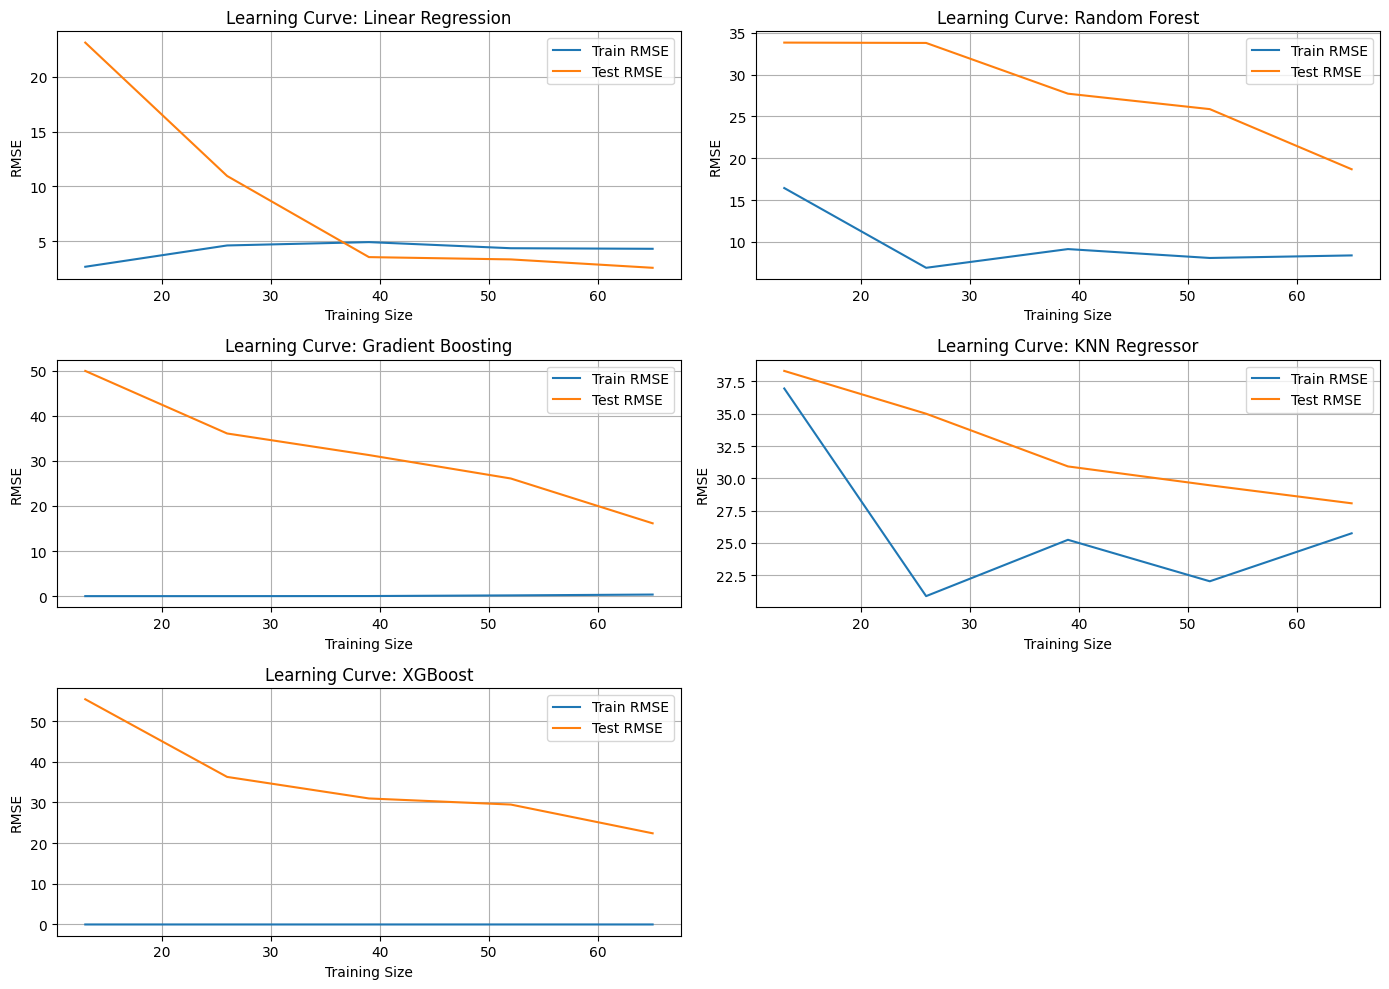

In [8]:
# Plot learning curves

# TimeSeriesSplit to respect temporal order
tscv = TimeSeriesSplit(n_splits=5)

plt.figure(figsize=(14, 10))

for i, (name, model) in enumerate(models.items(), 1):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=tscv, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.2, 1.0, 5), shuffle=False)

    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))

    plt.subplot(3, 2, i)
    plt.plot(train_sizes, train_rmse, label='Train RMSE')
    plt.plot(train_sizes, test_rmse, label='Test RMSE')
    plt.title(f'Learning Curve: {name}')
    plt.xlabel('Training Size')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

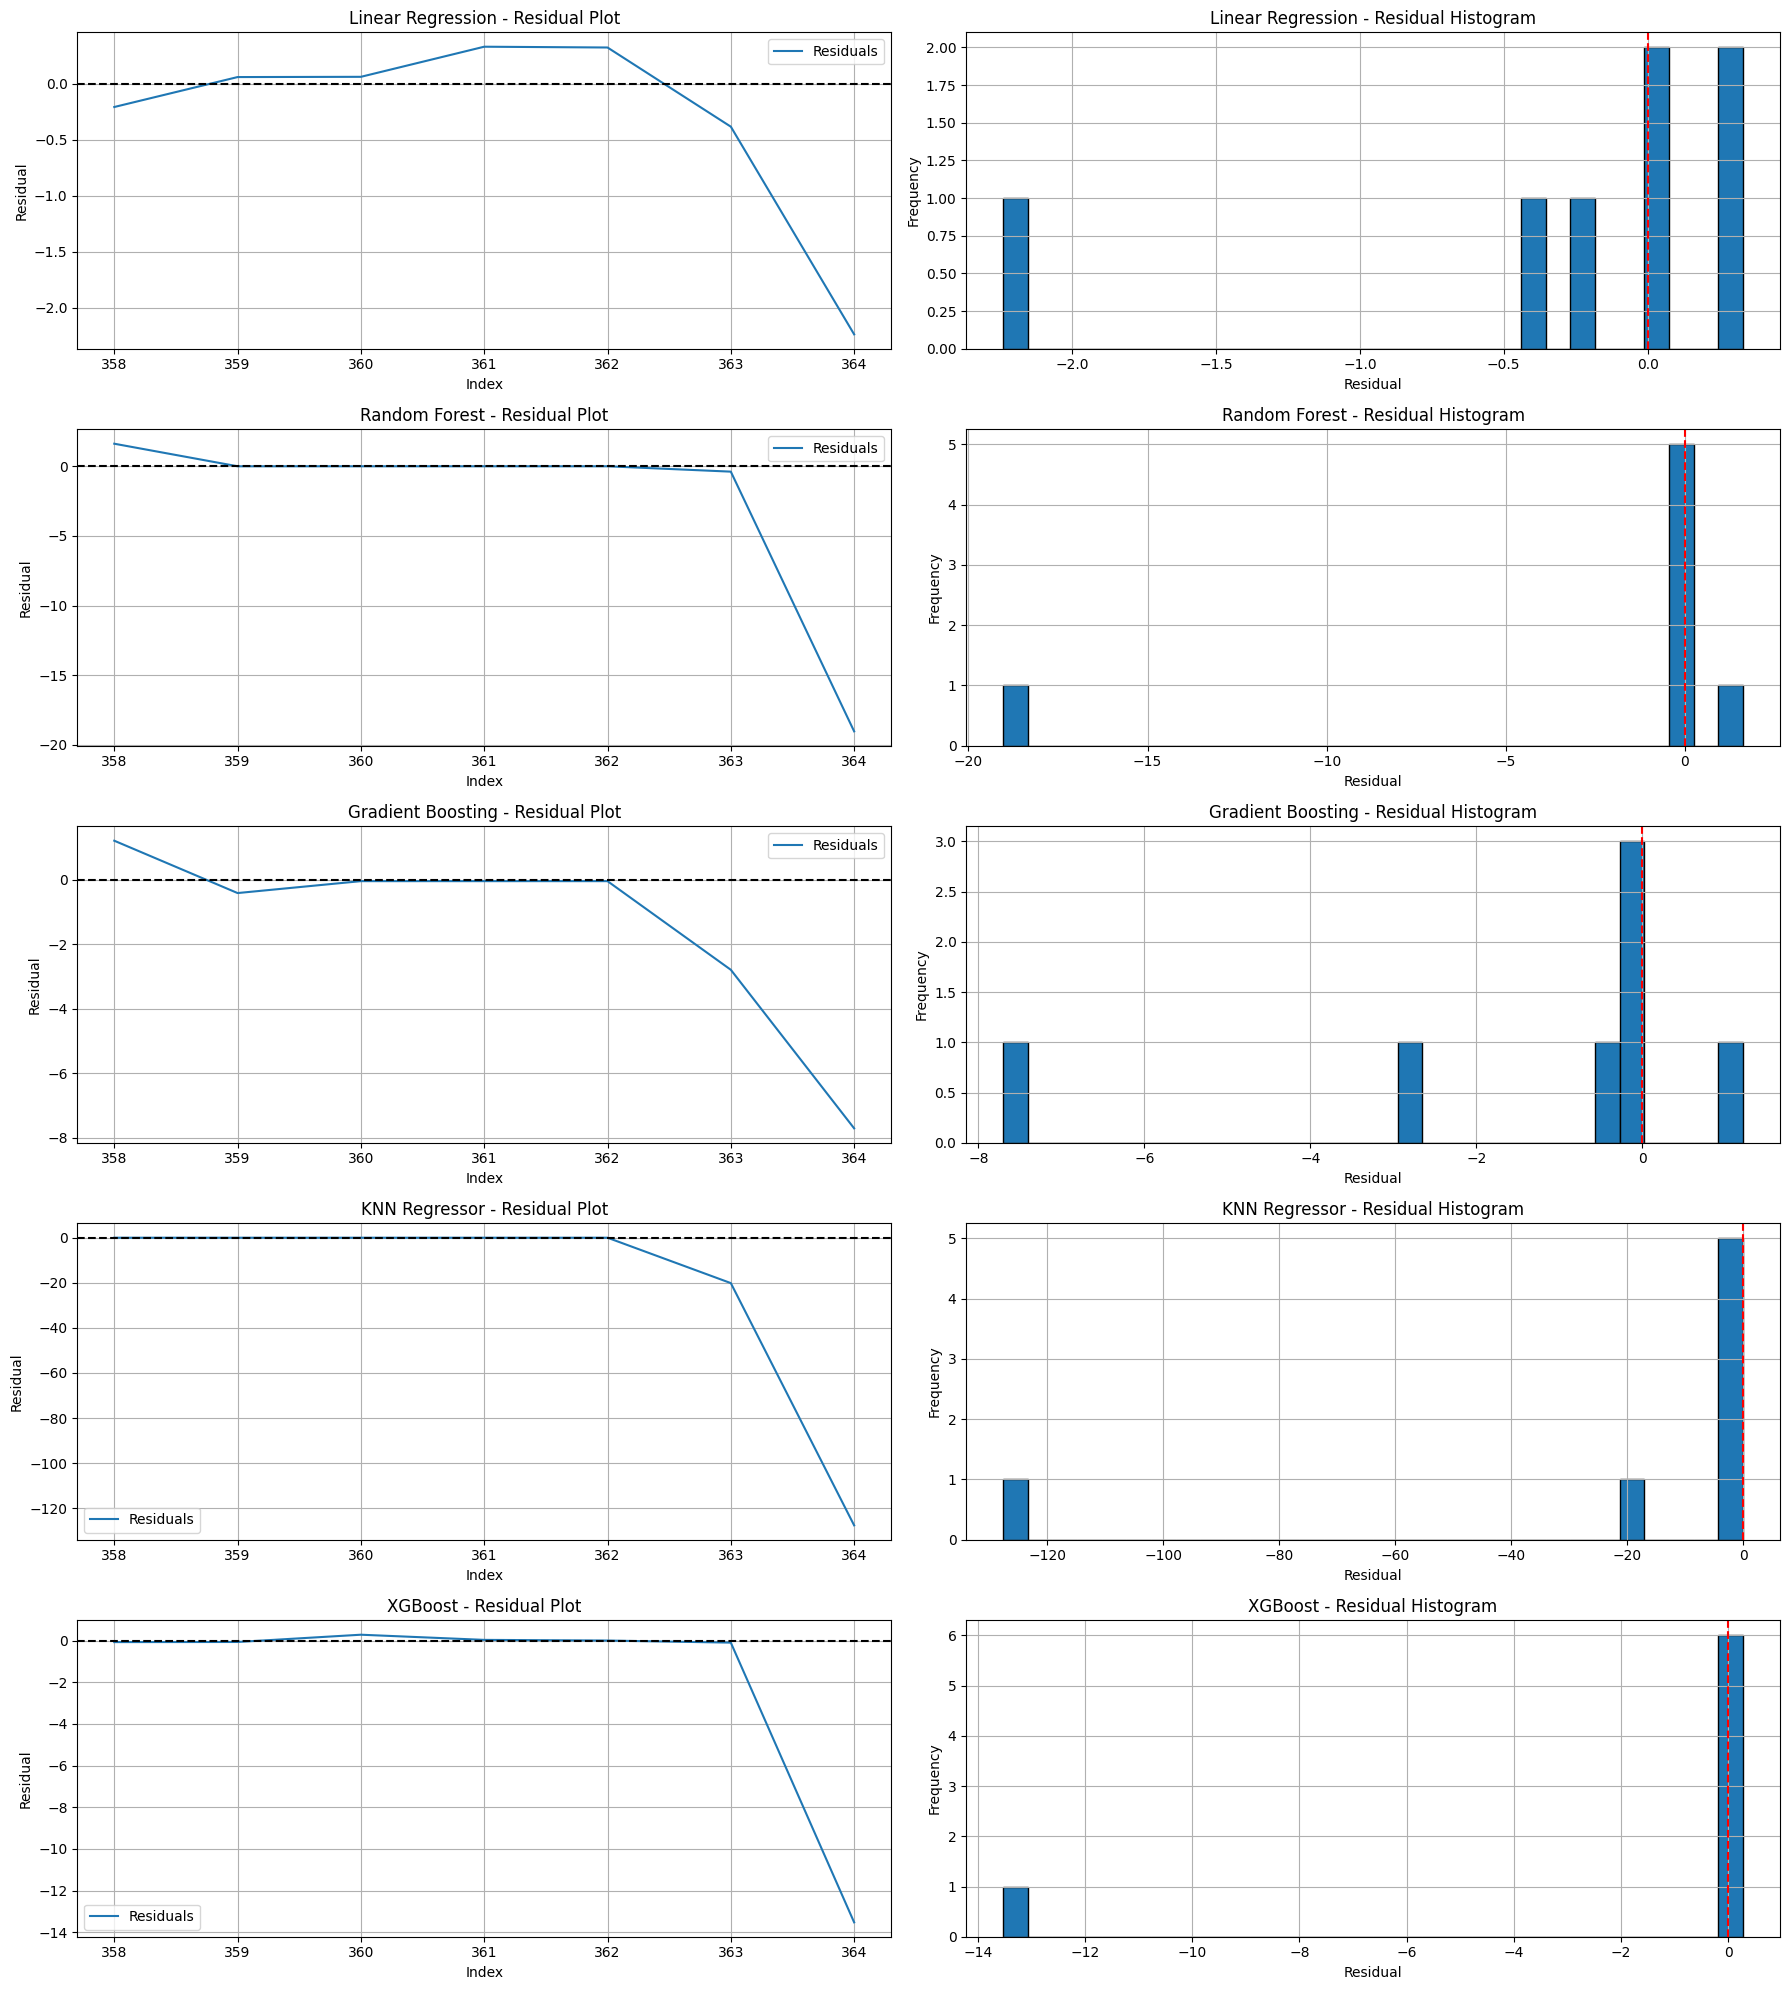

In [9]:
# Plot residuals and histograms
plt.figure(figsize=(18, 20))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    residuals = y_test - preds

    # Residual Line Plot
    plt.subplot(len(models), 2, 2*i+1)
    plt.plot(residuals, label='Residuals')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'{name} - Residual Plot')
    plt.xlabel('Index')
    plt.ylabel('Residual')
    plt.grid(True)
    plt.legend()

    # Residual Histogram
    plt.subplot(len(models), 2, 2*i+2)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f'{name} - Residual Histogram')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Top 3 Time Series Models:

- 1. Prophet
- 2. SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous regressors)
- 3. Exponential Smoothing (no regressors)

In [10]:
# Prepare df for Prophet
df_prophet = df[['Daily Date', 'Total Price'] + features].rename(columns={'Daily Date': 'ds', 'Total Price': 'y'})

In [11]:
# Split train/test (last 7 days as test)
train_df = df_prophet[:-7]
test_df = df_prophet[-7:]

In [12]:
# Forecast horizon based on your test_df
forecast_horizon = len(test_df)

### 1. Prophet with Regressors
prophet = Prophet()
for reg in features:
    prophet.add_regressor(reg)

prophet.fit(train_df)
future = test_df[['ds'] + features]  # already the last 7 days
forecast = prophet.predict(future)
prophet_preds = forecast['yhat'].values
prophet_actual = test_df['y'].values
prophet_mape = np.mean(np.abs((prophet_actual - prophet_preds) / np.maximum(prophet_actual, 1e-8))) * 100
prophet_rmse = np.sqrt(mean_squared_error(prophet_actual, prophet_preds))

### 2. SARIMAX with exogenous variables
sarimax_model = SARIMAX(train_df['y'], exog=train_df[features], order=(1,1,1), seasonal_order=(1,1,1,7))
sarimax_result = sarimax_model.fit(disp=False)
sarimax_preds = sarimax_result.forecast(steps=forecast_horizon, exog=test_df[features])
sarimax_actual = test_df['y'].values
sarimax_mape = np.mean(np.abs((sarimax_actual - sarimax_preds) / np.maximum(sarimax_actual, 1e-8))) * 100
sarimax_rmse = np.sqrt(mean_squared_error(sarimax_actual, sarimax_preds))

### 3. Exponential Smoothing (no regressors)
ets_model = ExponentialSmoothing(train_df['y'], trend='add', seasonal='add', seasonal_periods=7)
ets_result = ets_model.fit()
ets_preds = ets_result.forecast(steps=forecast_horizon)
ets_actual = test_df['y'].values
ets_mape = np.mean(np.abs((ets_actual - ets_preds) / np.maximum(ets_actual, 1e-8))) * 100
ets_rmse = np.sqrt(mean_squared_error(ets_actual, ets_preds))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclaylyj9/4fxmu_6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclaylyj9/qli8fh4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37843', 'data', 'file=/tmp/tmpclaylyj9/4fxmu_6u.json', 'init=/tmp/tmpclaylyj9/qli8fh4p.json', 'output', 'file=/tmp/tmpclaylyj9/prophet_modeldb3q8nv2/prophet_model-20250515054000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:40:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:40:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

In [13]:
# Store results
ts_results = [
    {'Model': 'Prophet with Regressors', 'RMSE': prophet_rmse, 'MAPE': prophet_mape},
    {'Model': 'SARIMAX with Regressors', 'RMSE': sarimax_rmse, 'MAPE': sarimax_mape},
    {'Model': 'Exponential Smoothing', 'RMSE': ets_rmse, 'MAPE': ets_mape}
]

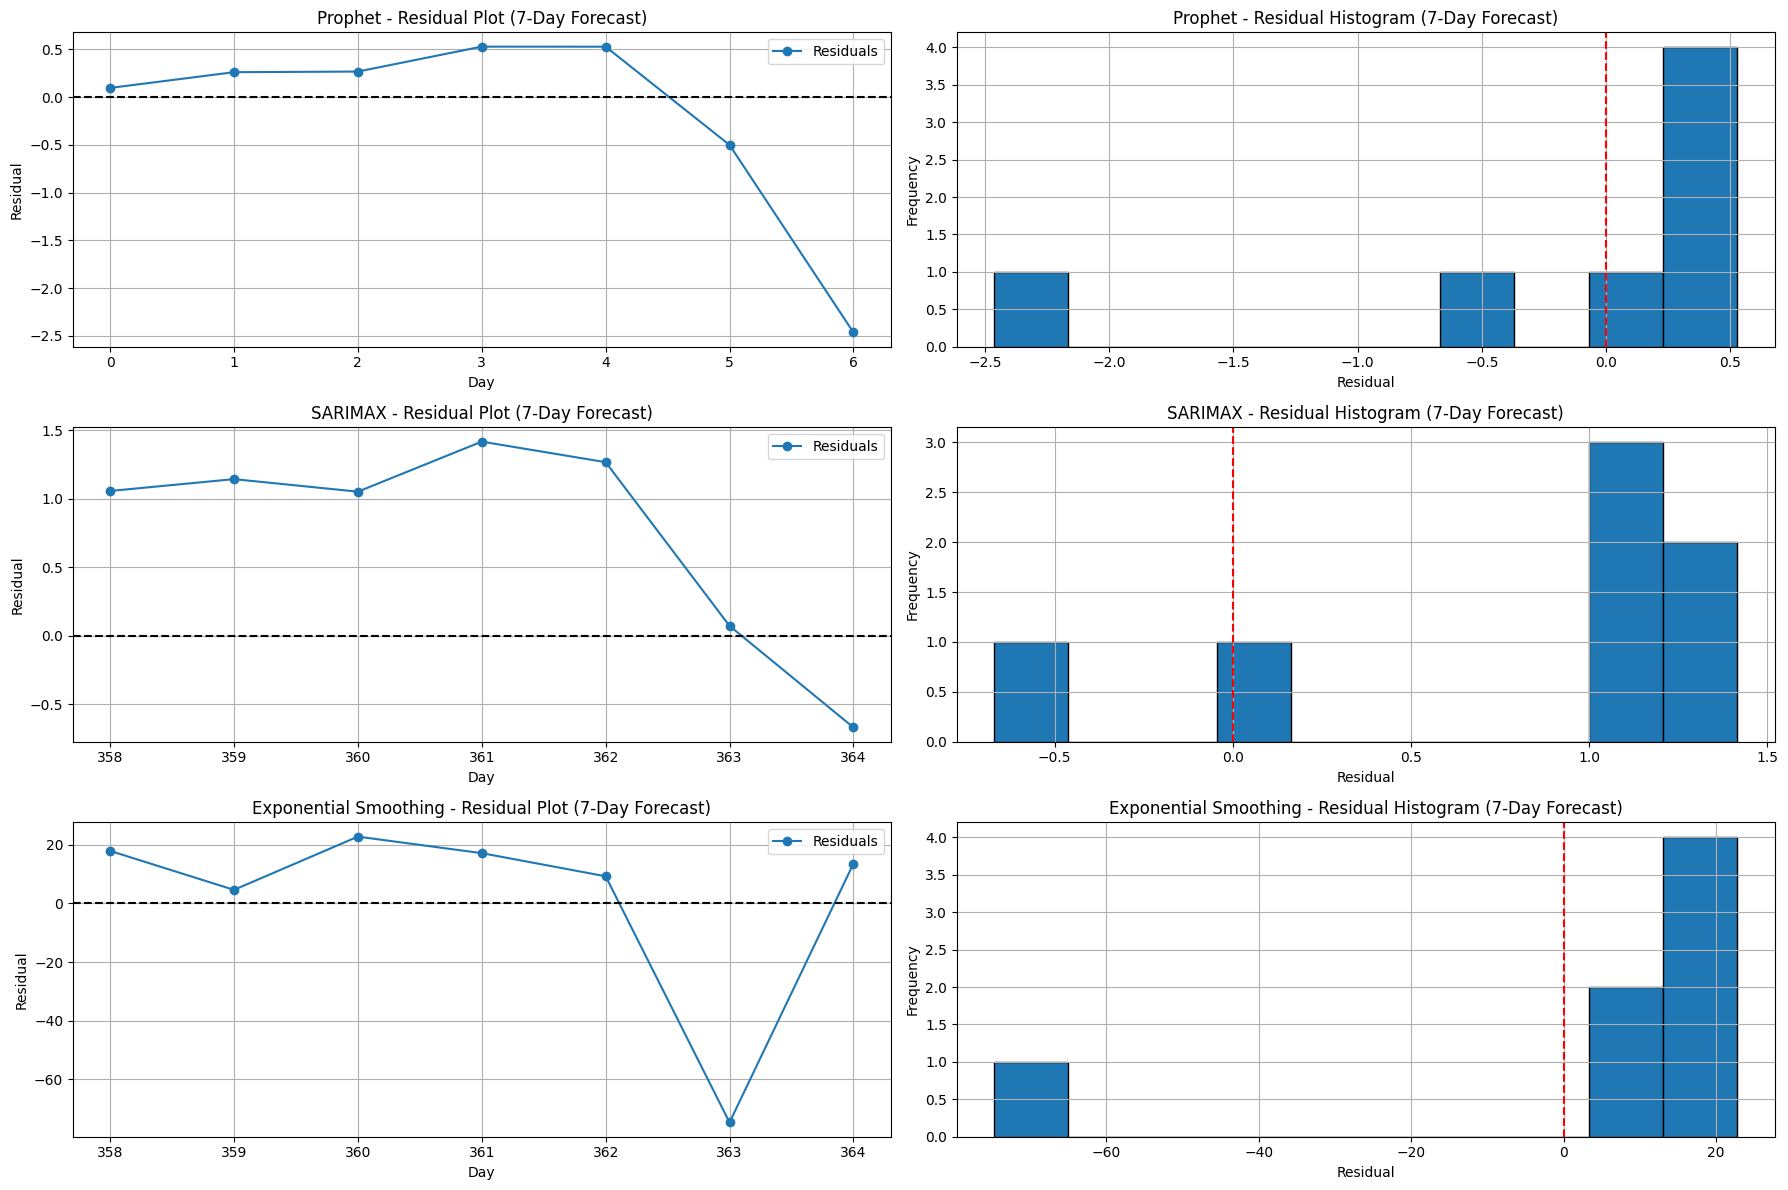

In [14]:
## error analysis and histogram of residual
# Compute residuals (assuming predictions are already done)
resid_prophet = test_df['y'].values - prophet_preds
resid_sarimax = test_df['y'].values - sarimax_preds
resid_ets = test_df['y'].values - ets_preds

# Dictionary for plotting
residuals_ts = {
    'Prophet': resid_prophet,
    'SARIMAX': resid_sarimax,
    'Exponential Smoothing': resid_ets
}

# Plot
plt.figure(figsize=(18, 12))

for i, (name, residuals) in enumerate(residuals_ts.items()):
    # Line Plot
    plt.subplot(len(residuals_ts), 2, 2*i+1)
    plt.plot(residuals, marker='o', label='Residuals')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'{name} - Residual Plot (7-Day Forecast)')
    plt.xlabel('Day')
    plt.ylabel('Residual')
    plt.grid(True)
    plt.legend()

    # Histogram
    plt.subplot(len(residuals_ts), 2, 2*i+2)
    plt.hist(residuals, bins=10, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f'{name} - Residual Histogram (7-Day Forecast)')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Top 2 Deep Learning Models

- 1. LSTM for 1-Day Forecast
- 2. CNN-LSTM Hybrid

In [15]:
# Prepare data for DL
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features + [target]])

# Create sequences (window = 5)
X1, y1 = [], []
for i in range(5, len(scaled)):
    X1.append(scaled[i-5:i, :-1])
    y1.append(scaled[i, -1])
X1, y1 = np.array(X1), np.array(y1)

# Train/test split
X_train, X_test = X1[:-7], X1[-7:]
y_train, y_test = y1[:-7], y1[-7:]

In [16]:
# 1. LSTM for 1 Day Forecast

# Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# Predict and evaluate
y_pred_lstm = model.predict(X_test)
mape = np.mean(np.abs((y_test - y_pred_lstm) / np.maximum(y_test, 1e-8))) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1912 - val_loss: 0.0145
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0241 - val_loss: 0.0123
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - val_loss: 0.0121
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0156 - val_loss: 0.0117
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198 - val_loss: 0.0116
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - val_loss: 0.0120
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0144 - val_loss: 0.0115
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0154 - val_loss: 0.0116
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0179 - val_loss: 0.0121
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137 - val_loss: 0.0116
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - val_loss: 0.01

In [17]:
# 2. CNN-LSTM Hybrid

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(LSTM(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mse')

# Train model
model_cnn.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# Predict and evaluate
y_pred_cnn = model_cnn.predict(X_test)
mape_cnn = np.mean(np.abs((y_test - y_pred_cnn) / np.maximum(y_test, 1e-8))) * 100
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0669 - val_loss: 0.0123
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0149 - val_loss: 0.0125
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - val_loss: 0.0118
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - val_loss: 0.0117
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0153 - val_loss: 0.0117
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0144 - val_loss: 0.0117
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0207 - val_loss: 0.0122
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0153 - val_loss: 0.0114
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0146 - val_loss: 0.0120
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0123 - val_loss: 0.0114
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121 - val_loss:

In [18]:
y_pred_cnn

array([[0.4136851 ],
       [0.43526673],
       [0.43494135],
       [0.45000607],
       [0.44528854],
       [0.42027184],
       [0.43483952]], dtype=float32)

In [19]:
# Store results
dl_results = [
    {'Model': 'LSTM', 'RMSE': rmse, 'MAPE': mape},
    {'Model': 'CNN-LSTM', 'RMSE': rmse_cnn, 'MAPE': mape_cnn}
]

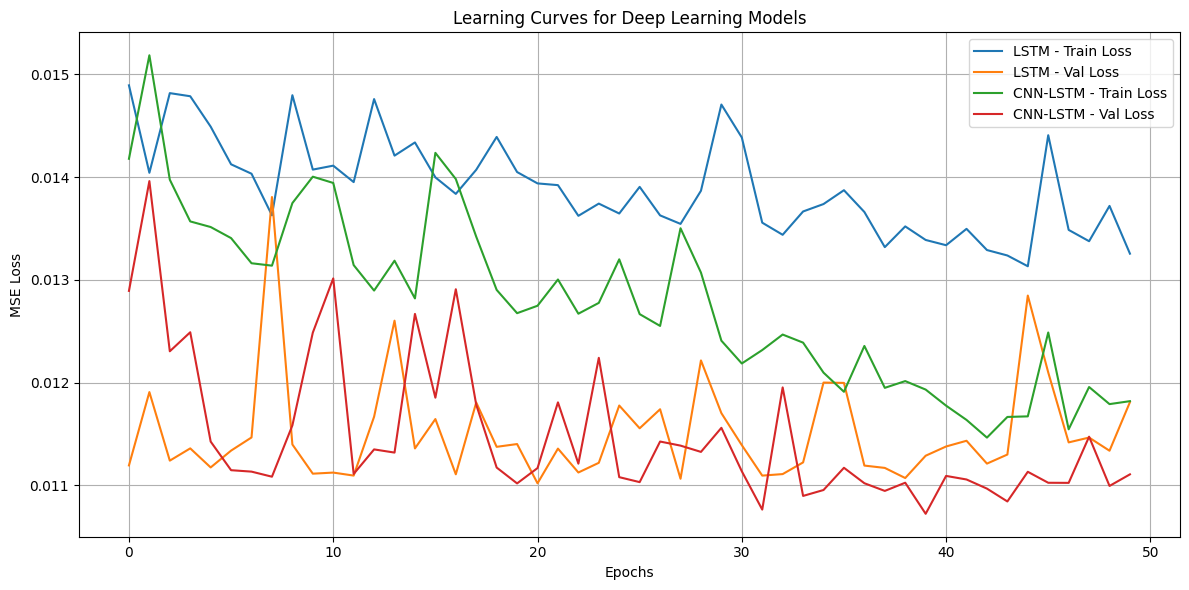

In [20]:
# Plot Learning Curve for LSTM and CNN-LSTM

# After training LSTM
history_lstm = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# After training CNN-LSTM
history_cnn = model_cnn.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Plotting learning curves
plt.figure(figsize=(12, 6))

# LSTM Loss
plt.plot(history_lstm.history['loss'], label='LSTM - Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM - Val Loss')

# CNN-LSTM Loss
plt.plot(history_cnn.history['loss'], label='CNN-LSTM - Train Loss')
plt.plot(history_cnn.history['val_loss'], label='CNN-LSTM - Val Loss')

plt.title('Learning Curves for Deep Learning Models')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

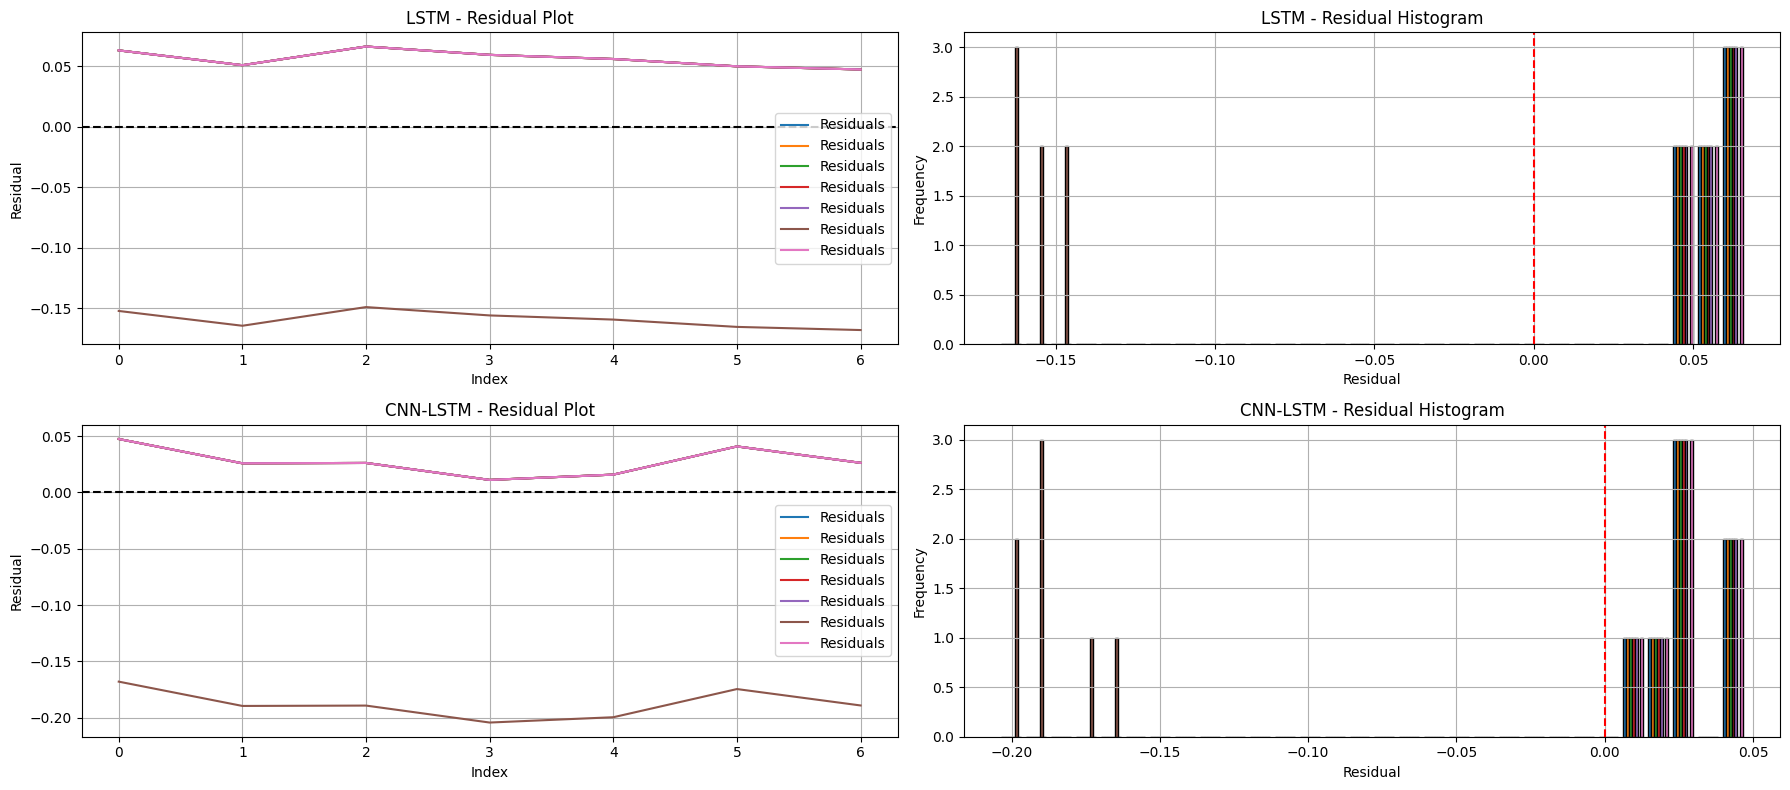

In [21]:
## error analysis and histogram of residual
# Compute residuals
resid_lstm = y_test - y_pred_lstm
resid_cnn = y_test - y_pred_cnn

residuals_dl = {
    'LSTM': resid_lstm,
    'CNN-LSTM': resid_cnn
}

# Plotting
plt.figure(figsize=(18, 8))

for i, (name, residuals) in enumerate(residuals_dl.items()):
    # Residual Line Plot
    plt.subplot(len(residuals_dl), 2, 2*i+1)
    plt.plot(residuals, label='Residuals')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'{name} - Residual Plot')
    plt.xlabel('Index')
    plt.ylabel('Residual')
    plt.grid(True)
    plt.legend()

    # Residual Histogram
    plt.subplot(len(residuals_dl), 2, 2*i+2)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f'{name} - Residual Histogram')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Comparison Table for all the above Models

In [22]:
# Combine all results into one DataFrame
comparison_df = pd.DataFrame(ml_results + ts_results + dl_results)

# Display sorted by RMSE ascending
comparison_df = comparison_df.sort_values(by='MAPE')
comparison_df

,Model,RMSE,MAPE
0,Linear Regression,0.880661,0.296509
5,Prophet with Regressors,1.001558,0.381882
6,SARIMAX with Regressors,1.040867,0.515921
2,Gradient Boosting,3.133384,1.079670
4,XGBoost,5.113366,1.086828
1,Random Forest,7.219758,1.634844
3,KNN Regressor,48.828359,12.363279
9,CNN-LSTM,0.070863,16.055373
7,Exponential Smoothing,31.652912,16.065683
8,LSTM,0.082207,19.714678


Overall, all 10 models performed well, but Linear Regression from ML, Prophet from Time Series, and CNN-LSTM from Deep Learning performed well.